<a href="https://colab.research.google.com/github/Dhanush-adk/intro_to_dl/blob/main/intro_to_dl/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:02<00:00, 62140989.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])


In [ ]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda'):
    if not train_loader or not test_loader:
        print("Empty data loaders. Exiting.")
        return None

    def calculate_metrics(predictions, targets):
        accuracy = 100 * sum([p == t for p, t in zip(predictions, targets)]) / len(targets)
        precision = precision_score(targets, predictions, average='weighted')
        recall = recall_score(targets, predictions, average='weighted')
        f1 = f1_score(targets, predictions, average='weighted')
        return accuracy, precision, recall, f1

    model.to(device)

    train_loss_list, val_loss_list, val_accuracy_list = [], [], []

    # Training loop
    epochs = 20
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(train_loader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        all_predictions, all_targets = [], []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.tolist())
                all_targets.extend(labels.tolist())

        val_loss_list.append(running_loss / len(test_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Final evaluation
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())

    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_targets)

    # Print the metrics
    print(f'\nFinal Evaluation Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Return metrics
    return {
        'train_loss': train_loss_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'final_accuracy': accuracy,
        'final_precision': precision,
        'final_recall': recall,
        'final_f1': f1,
        'all_targets': all_targets,
        'all_predictions': all_predictions,
        'model': model
    }

In [ ]:
# Define the model and move it to the GPU if available
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
metrics = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader)

Epoch 1, Training loss: 1.7681, Validation loss: 1.5887, Validation Accuracy: 43.88%
Epoch 2, Training loss: 1.5115, Validation loss: 1.4712, Validation Accuracy: 48.36%
Epoch 3, Training loss: 1.3988, Validation loss: 1.4143, Validation Accuracy: 49.83%
Epoch 4, Training loss: 1.3156, Validation loss: 1.3882, Validation Accuracy: 50.66%
Epoch 5, Training loss: 1.2471, Validation loss: 1.3406, Validation Accuracy: 52.57%
Epoch 6, Training loss: 1.1833, Validation loss: 1.3602, Validation Accuracy: 52.17%
Epoch 7, Training loss: 1.1261, Validation loss: 1.3630, Validation Accuracy: 52.20%
Epoch 8, Training loss: 1.0720, Validation loss: 1.3183, Validation Accuracy: 54.23%
Epoch 9, Training loss: 1.0198, Validation loss: 1.3491, Validation Accuracy: 52.99%
Epoch 10, Training loss: 0.9737, Validation loss: 1.3670, Validation Accuracy: 53.50%
Epoch 11, Training loss: 0.9238, Validation loss: 1.3884, Validation Accuracy: 53.40%
Epoch 12, Training loss: 0.8763, Validation loss: 1.3642, Valid

<Figure size 1000x800 with 0 Axes>

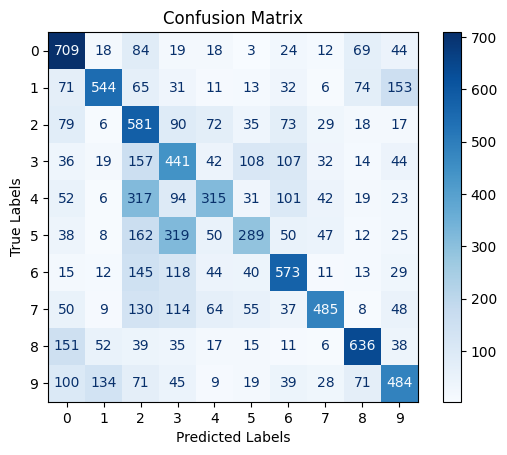

In [ ]:
cm = confusion_matrix(metrics['all_targets'], metrics['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
total_params = sum(p.numel() for p in metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 1640330


In [ ]:
# Save the model weights
torch.save(metrics['model'].state_dict(), 'cifar10model1.pth')  # .pth is the recommended extension

In [ ]:
epochs_list = [i for i in range(1, 20+1, 1)]

In [ ]:
len(epochs_list)

20

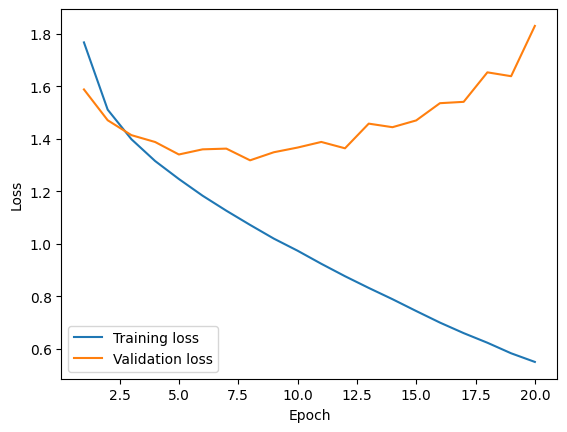

In [ ]:
plt.plot(epochs_list, metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
class ModelNet_2(nn.Module):
    def __init__(self):
        super(ModelNet_2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
# Define the model and move it to the GPU if available
model2 = ModelNet_2().to(device)

# Loss function and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model.parameters(), lr=0.00000000001)

In [ ]:
model2_metrics = train_and_evaluate_model(model2, criterion2, optimizer2, train_loader, test_loader)

Epoch 1, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 2, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 3, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 4, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 5, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 6, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 7, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 8, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 9, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 10, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 11, Training loss: 2.3046, Validation loss: 2.3047, Validation Accuracy: 8.54%
Epoch 12, Training loss: 2.3046, Validation loss: 2.3047, Validation Accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x800 with 0 Axes>

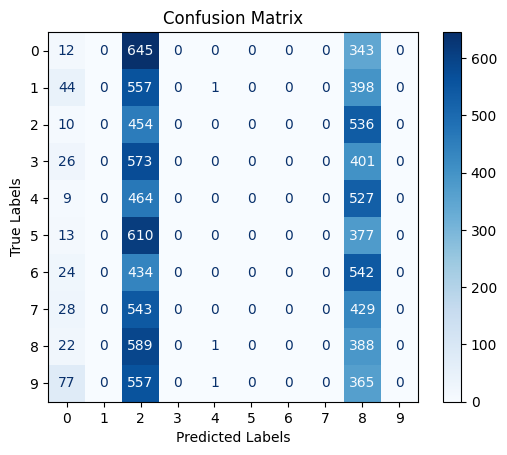

In [ ]:
cm = confusion_matrix(model2_metrics['all_targets'], model2_metrics['all_predictions'])
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model2_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 3738506


In [ ]:
# Save the model weights
torch.save(model2_metrics['model'].state_dict(), 'cifar10model2.pth')  # .pth is the recommended extension

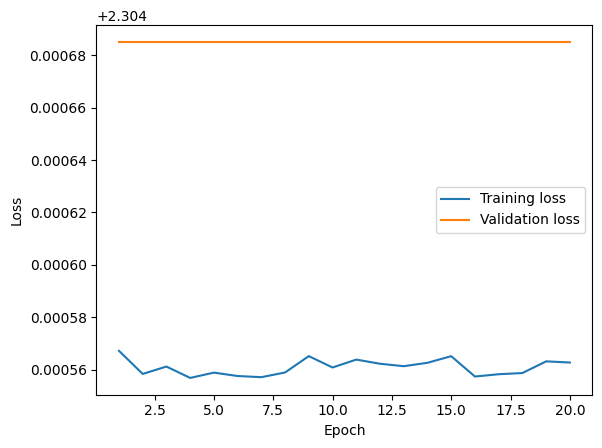

In [ ]:
plt.plot(epochs_list, model2_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model2_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()